## importing necessary modules

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
import random
import pickle

2024-06-19 19:01:34.253462: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-19 19:01:35.557654: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-19 19:01:35.564222: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-19 19:01:40.892559: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
Directory = r'/mnt/c/Users/sanatan/OneDrive/Desktop/Shrig_learning/Assignments/Tensorflow_Basics/datasets/archive/Dog and Cat .png'

In [3]:
Categories = ['Cat', 'Dog']

## PreProcessing the data

- Assign directory
- Resize the iamge
- Adding the labels to the images

In [4]:
data = []

for category in Categories:
    folder = os.path.join(Directory, category)
    label = Categories.index(category)
    for img in os.listdir(folder):
        img_path = os.path.join(folder, img)
        img_arr = cv2.imread(img_path)
        img_arr = cv2.resize(img_arr,(100,100))
        data.append([img_arr, label])

In [5]:
len(data)

1000

In [6]:
random.shuffle(data)

In [7]:
X = []
y = []
for features, labels in data:
    X.append(features)
    y.append(labels)

In [8]:
X = np.array(X)
y = np.array(y)

In [9]:
len(X)
len(y)

1000

Saving the dataset so that we don't have to preprocess it again and again

In [10]:
pickle.dump(X, open('X.pkl','wb'))
pickle.dump(y, open('y.pkl','wb'))

## Implementing the Model

In [3]:
X = pickle.load(open('X.pkl','rb'))
y = pickle.load(open('y.pkl','rb'))

In [4]:
X =X/225

In [5]:
X.shape

(1000, 100, 100, 3)

In [6]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [20]:
def VGG(X, y, learning_rate):
  """
  Creates a simplified VGG-like model with multiple convolutional blocks.

  Args:
      X: Training data (numpy array of images).
      y: Training labels (numpy array).
      learning_rate: Learning rate for the optimizer.

  Returns:
      A compiled Keras model.
  """

  model = Sequential()

  model.add(Conv2D(64, (3, 3), activation='relu', input_shape=X.shape[1:]))
  model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(MaxPooling2D((2, 2)))

  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(MaxPooling2D((2, 2)))

  model.add(Conv2D(256, (3, 3), activation='relu'))
  model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
  model.add(MaxPooling2D((2, 2)))

  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(2, activation='softmax'))

  optimizer = Adam(learning_rate=learning_rate)
  model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  history = model.fit(X, y, epochs=5, validation_split=0.2)

  return model, history


In [8]:
print(X.shape[1:])

(100, 100, 3)


In [21]:
learning_rate = 0.0001
model, history = VGG(X,y, learning_rate)

Epoch 1/5
25/25 [==============================] - 44s 1s/step - loss: 0.6957 - accuracy: 0.5063 - val_loss: 0.6901 - val_accuracy: 0.5150
Epoch 2/5
25/25 [==============================] - 33s 1s/step - loss: 0.6848 - accuracy: 0.5425 - val_loss: 0.6714 - val_accuracy: 0.5950
Epoch 3/5
25/25 [==============================] - 32s 1s/step - loss: 0.6813 - accuracy: 0.5475 - val_loss: 0.6668 - val_accuracy: 0.6150
Epoch 4/5
25/25 [==============================] - 32s 1s/step - loss: 0.6569 - accuracy: 0.6187 - val_loss: 0.6602 - val_accuracy: 0.5950
Epoch 5/5
25/25 [==============================] - 32s 1s/step - loss: 0.6115 - accuracy: 0.6712 - val_loss: 0.6431 - val_accuracy: 0.5950


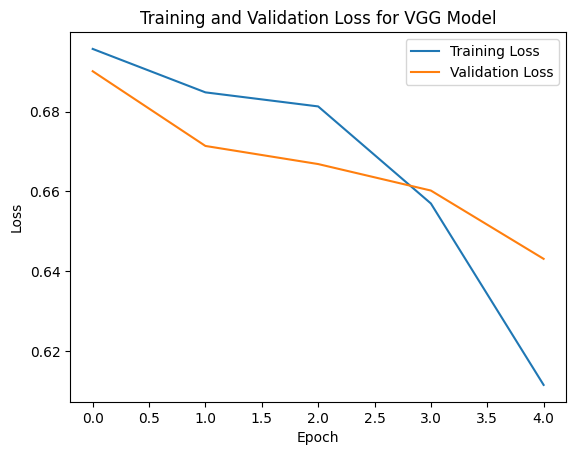

In [22]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss for VGG Model')
plt.show()

## Trying Resnet to see how it works

In [10]:
from tensorflow.keras.applications import ResNet50  # Or any other pre-trained ResNet variant
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [11]:
from keras.models import Model

In [23]:

def create_resnet_model( X, y, learning_rate = 0.001, input_shape=(224, 224, 3), num_classes=10, freeze_layers=True):
  """
  Creates a ResNet model for fine-tuning on a classification task.

  Args:
      input_shape: Shape of the input image (default: (224, 224, 3)).
      num_classes: Number of classes in your classification task.
      freeze_layers: Whether to freeze the pre-trained layers (default: True).

  Returns:
      A compiled Keras model.
  """

  # Load the pre-trained ResNet50 model
  resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

  # Freeze pre-trained layers if specified
  if freeze_layers:
    for layer in resnet_base.layers:
      layer.trainable = False

  # Add custom layers for classification
  x = resnet_base.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(1024, activation='relu')(x)  # Example dense layer (adjust units as needed)
  predictions = Dense(num_classes, activation='softmax')(x)

  # Create the final model
  model = Model(inputs=resnet_base.input, outputs=predictions)

  # Compile the model
  optimizer = Adam(learning_rate=learning_rate)
  model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  history = model.fit(X,y,epochs=5, validation_split=0.2)

  return model, history

In [25]:
model_res, history_res = create_resnet_model( X, y, learning_rate = 0.001,input_shape= (100, 100, 3))

Epoch 1/5
25/25 [==============================] - 36s 959ms/step - loss: 1.1029 - accuracy: 0.5050 - val_loss: 0.7420 - val_accuracy: 0.5450
Epoch 2/5
25/25 [==============================] - 14s 563ms/step - loss: 0.7823 - accuracy: 0.5487 - val_loss: 0.6684 - val_accuracy: 0.6050
Epoch 3/5
25/25 [==============================] - 11s 443ms/step - loss: 0.7337 - accuracy: 0.5537 - val_loss: 0.6568 - val_accuracy: 0.5900
Epoch 4/5
25/25 [==============================] - 10s 410ms/step - loss: 0.7158 - accuracy: 0.5612 - val_loss: 0.6870 - val_accuracy: 0.5500
Epoch 5/5
25/25 [==============================] - 10s 409ms/step - loss: 0.6834 - accuracy: 0.6062 - val_loss: 0.9396 - val_accuracy: 0.5050


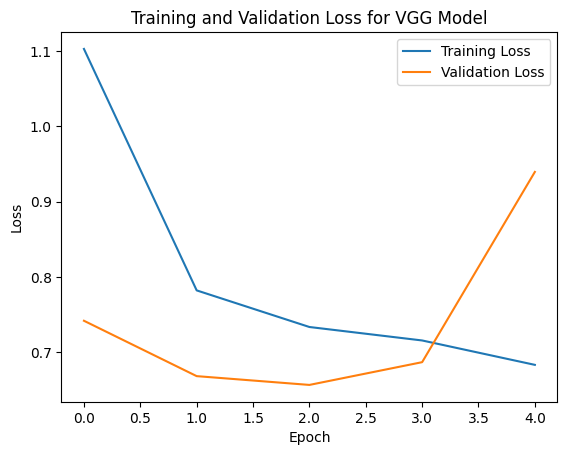

In [26]:
train_loss = history_res.history['loss']
val_loss = history_res.history['val_loss']

# Plot the loss curves
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss for VGG Model')
plt.show()

## Inception Net

In [12]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [17]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers

In [46]:
def inception_net(X, y):
      """
    Creates a Inceoption Net model for fine-tuning on a classification task.

    Args:
    X : features
    y : target

    Returns:
      A compiled Keras model.
  """
    pre_trained_model = InceptionV3(input_shape=(100,100,3), include_top= False, weights = 'imagenet')
    for layer in pre_trained_model.layers:
        layer.trainble = False
    x = layers.Flatten()(pre_trained_model.output)
    x = layers.Dense(1024, activation = 'relu')(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(1, activation = 'sigmoid')(x)
    model = Model(pre_trained_model.input, x)

    model.compile(optimizer = Adam(learning_rate=0.0001),
                loss='binary_crossentropy',
                metrics='acc')
    history_incep = model.fit(X,y, epochs=6, validation_split=0.2)
    return model, history_incep

In [52]:
model, history_incep = inception_net(X, y)

Epoch 1/6
25/25 [==============================] - 96s 1s/step - loss: 0.7173 - acc: 0.5475 - val_loss: 0.6515 - val_acc: 0.6700
Epoch 2/6
25/25 [==============================] - 23s 883ms/step - loss: 0.5916 - acc: 0.7125 - val_loss: 1.0151 - val_acc: 0.6050
Epoch 3/6
25/25 [==============================] - 20s 801ms/step - loss: 0.4305 - acc: 0.8375 - val_loss: 0.7420 - val_acc: 0.7450
Epoch 4/6
25/25 [==============================] - 20s 799ms/step - loss: 0.2672 - acc: 0.8975 - val_loss: 0.5230 - val_acc: 0.7900
Epoch 5/6
25/25 [==============================] - 20s 788ms/step - loss: 0.1532 - acc: 0.9488 - val_loss: 0.4861 - val_acc: 0.8150
Epoch 6/6
25/25 [==============================] - 20s 787ms/step - loss: 0.1128 - acc: 0.9625 - val_loss: 0.5843 - val_acc: 0.7950


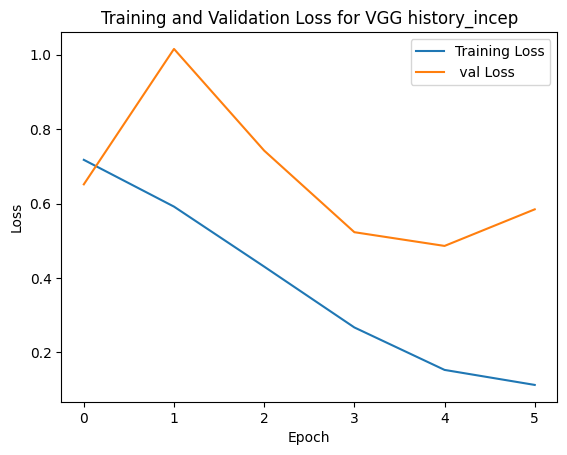

In [54]:
train_loss = history_incep.history['loss']
val_loss = history_incep.history['val_loss']
# Plot the loss curves
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label=' val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss for VGG history_incep')
plt.show()

## testing the model for varaying learning rate

In [55]:
def inception_net(X, y, learning_rate=0.0001):
  """
  Creates a Inception Net model for fine-tuning on a classification task.

  Args:
    X: Features.
    y: Target labels.
    learning_rate: Learning rate for the optimizer (default: 0.0001).

  Returns:
    A compiled Keras model and training history.
  """
  pre_trained_model = InceptionV3(input_shape=(100, 100, 3), include_top=False, weights='imagenet')
  for layer in pre_trained_model.layers:
    layer.trainable = False
  x = layers.Flatten()(pre_trained_model.output)
  x = layers.Dense(1024, activation='relu')(x)
  x = layers.Dropout(0.4)(x)
  x = layers.Dense(1, activation='sigmoid')(x)
  model = Model(pre_trained_model.input, x)

  model.compile(optimizer=Adam(learning_rate=learning_rate),
                loss='binary_crossentropy',
                metrics='acc')

  history_incep = model.fit(X, y, epochs=10, validation_split=0.2)
  return model, history_incep

learning_rates = [0.0001, 0.001, 0.00001] 
models_and_histories = []

for lr in learning_rates:
  model, history = inception_net(X, y, learning_rate=lr)
  models_and_histories.append((model, history))


Epoch 1/10
25/25 [==============================] - 29s 556ms/step - loss: 0.6394 - acc: 0.7113 - val_loss: 0.5732 - val_acc: 0.7600
Epoch 2/10
25/25 [==============================] - 6s 241ms/step - loss: 0.3550 - acc: 0.8462 - val_loss: 0.4364 - val_acc: 0.8550
Epoch 3/10
25/25 [==============================] - 4s 177ms/step - loss: 0.2540 - acc: 0.8913 - val_loss: 0.4129 - val_acc: 0.8500
Epoch 4/10
25/25 [==============================] - 4s 160ms/step - loss: 0.2029 - acc: 0.9025 - val_loss: 0.4214 - val_acc: 0.8650
Epoch 5/10
25/25 [==============================] - 4s 159ms/step - loss: 0.1524 - acc: 0.9400 - val_loss: 0.3837 - val_acc: 0.8500
Epoch 6/10
25/25 [==============================] - 4s 155ms/step - loss: 0.1260 - acc: 0.9538 - val_loss: 0.4759 - val_acc: 0.8600
Epoch 7/10
25/25 [==============================] - 4s 173ms/step - loss: 0.1187 - acc: 0.9588 - val_loss: 0.4528 - val_acc: 0.8550
Epoch 8/10
25/25 [==============================] - 4s 150ms/step - loss: 0

In [66]:
models_and_histories[0][1].history

{'loss': [0.6393531560897827,
  0.35497012734413147,
  0.25396737456321716,
  0.20289655029773712,
  0.15240593254566193,
  0.12601202726364136,
  0.11872057616710663,
  0.08105973899364471,
  0.08584827184677124,
  0.07585931569337845],
 'acc': [0.7112500071525574,
  0.8462499976158142,
  0.8912500143051147,
  0.9024999737739563,
  0.9399999976158142,
  0.9537500143051147,
  0.9587500095367432,
  0.9800000190734863,
  0.981249988079071,
  0.9787499904632568],
 'val_loss': [0.5731812119483948,
  0.43644076585769653,
  0.41289645433425903,
  0.42141276597976685,
  0.3836555480957031,
  0.4759121835231781,
  0.45279407501220703,
  0.4236101806163788,
  0.4311973452568054,
  0.4541027545928955],
 'val_acc': [0.7599999904632568,
  0.8550000190734863,
  0.8500000238418579,
  0.8650000095367432,
  0.8500000238418579,
  0.8600000143051147,
  0.8550000190734863,
  0.8500000238418579,
  0.8600000143051147,
  0.8299999833106995]}

In [67]:
val_acc = []
val_loss = []
for model, history in models_and_histories:
  val_acc.append(history.history['val_accuracy'])
  val_loss.append(history.history['val_loss'])

plt.figure(figsize=(10, 6))
for i, lr in enumerate(learning_rates):
  plt.plot(history.epoch, val_acc[i], label=f'Learning Rate: {lr}')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. Learning Rate')
plt.legend()
plt.grid(True)
plt.show()

<keras.src.engine.functional.Functional object at 0x7f0b358dbcd0> <keras.src.callbacks.History object at 0x7f0b358a8c10>
<keras.src.engine.functional.Functional object at 0x7f0b3553ab80> <keras.src.callbacks.History object at 0x7f0b3548fdc0>
<keras.src.engine.functional.Functional object at 0x7f0b3551a130> <keras.src.callbacks.History object at 0x7f0b35509d00>
